In [12]:
import torch
import polars as pl
from transformers import AutoTokenizer, AutoModelForSequenceClassification
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("> using", device)
LABEL_NAMES = ["ENTAILMENT", "NEUTRAL", "CONTRADICTION"]
input_file_1 = "data/gpt4o_raw_03.06.2024.csv"
input_file_2 = "data/GPT-4o_raw_single_class_prompt.csv"
output_name = "data/gpt4o-03.04_and_single_class_prompt.csv"
df1 = pl.read_csv(input_file_1)
df2 = pl.read_csv(input_file_2)
df = pl.concat([df1, df2])
print("DF1 samples", df1.height)
print("DF2 samples", df2.height)
print("Total samples", df.height)
df.columns

> using cuda
DF1 samples 17
DF2 samples 29
Total samples 46


['cid',
 'premise',
 'hypothesis',
 'label',
 'Generated ENTAILMENT Hypothesis',
 'ENTAILMENT Correct?',
 'ENTAILMENT Adversarial?',
 'Generated NEUTRAL Hypothesis',
 'NEUTRAL Correct?',
 'NEUTRAL Adversarial',
 'Generated CONTRADICTION Hypothesis',
 'CONTRADICTION Correct?',
 'CONTRADICTION Adversarial']

# Compute the scores
Check whether the samples generated by LLama3 that are *correct* (i.e., checked by a human), are also *difficult* for the model (i.e., the model fails to classify them correctly).

This section only writes on another `.csv` file the results.

In [13]:
MODELS = {}
TOKENIZERS = {}

model_name_base = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli"
model_name_large = "MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli"
model_name_large_2 = "Joelzhang/deberta-v3-large-snli_mnli_fever_anli_R1_R2_R3-nli"
MAP = {
    'base' : model_name_base,
    'large1': model_name_large,
    'large2': model_name_large_2,
}

for model_name in MAP.values():
    print(f"> loading {model_name}")
    TOKENIZERS[model_name] = AutoTokenizer.from_pretrained(model_name, cache_dir='./.hf_cache')
    MODELS[model_name] = AutoModelForSequenceClassification.from_pretrained(model_name, cache_dir='./.hf_cache').to(device)


def inference(model_name, premise, hypothesis):
    model_input = TOKENIZERS[model_name](premise, hypothesis, truncation=False, return_tensors="pt")
    output = MODELS[model_name](model_input["input_ids"].to(device))  # device = "cuda:0" or "cpu"
    prediction = torch.softmax(output["logits"][0], -1).tolist()
    return {name: round(float(pred) * 100, 1) for pred, name in zip(prediction, LABEL_NAMES)}

def predict(model_name, premise, hypothesis, label):
    prediction = inference(model_name, premise, hypothesis)
    predicted = max(prediction, key=prediction.get)
    return int(predicted != label)

> loading MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli
> loading MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli
> loading Joelzhang/deberta-v3-large-snli_mnli_fever_anli_R1_R2_R3-nli


/home/gioffre/miniconda3/envs/aganlis/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:562: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [14]:
from tqdm import tqdm
from pprint import pprint
res = {}
for label in LABEL_NAMES:
    for model_id in MAP.keys():
        res[f"new {label} hypothesis fools {model_id.upper()}"] = []
#pprint(res)

for model_id, model_name in MAP.items():
    for i, elem in tqdm(enumerate(df.iter_rows(named=True)), desc=f'> model {model_id}', total=df.height):
        for label in LABEL_NAMES:
            # filters empty cells
            if elem[f'Generated {label} Hypothesis'] == '':
                continue
            if elem[f'{label} Correct?'] == True:
                int_flag = predict(model_name, elem['premise'], elem['hypothesis'], elem['label'])
                res[f'new {label} hypothesis fools {model_id.upper()}'].append(int_flag)
            else:
                res[f'new {label} hypothesis fools {model_id.upper()}'].append(None)
#pprint(res)

> model large2: 100%|██████████| 46/46 [00:02<00:00, 18.58it/s]


In [15]:
print(res)

{'new ENTAILMENT hypothesis fools BASE': [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], 'new ENTAILMENT hypothesis fools LARGE1': [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], 'new ENTAILMENT hypothesis fools LARGE2': [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], 'new NEUTRAL hypothesis fools BASE': [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, None, None, None, None, None, None, None, None, None, None, None, 1, 0, 0, 0, 0, 0, 1, 0, 0, None, None, None, None, None, None, None, None, None, None], 'new NEUTRAL hypothesis fools LARGE1': [0, 0

In [16]:
for label in LABEL_NAMES:
    for model_id in MAP.keys():
        df = df.with_columns(
            pl.Series(
                name=f"new {label} hypothesis fools {model_id.upper()}", 
                values=res[f"new {label} hypothesis fools {model_id.upper()}"]
            ),
        )
df.columns
df.head()

cid,premise,hypothesis,label,Generated ENTAILMENT Hypothesis,ENTAILMENT Correct?,ENTAILMENT Adversarial?,Generated NEUTRAL Hypothesis,NEUTRAL Correct?,NEUTRAL Adversarial,Generated CONTRADICTION Hypothesis,CONTRADICTION Correct?,CONTRADICTION Adversarial,new ENTAILMENT hypothesis fools BASE,new ENTAILMENT hypothesis fools LARGE1,new ENTAILMENT hypothesis fools LARGE2,new NEUTRAL hypothesis fools BASE,new NEUTRAL hypothesis fools LARGE1,new NEUTRAL hypothesis fools LARGE2,new CONTRADICTION hypothesis fools BASE,new CONTRADICTION hypothesis fools LARGE1,new CONTRADICTION hypothesis fools LARGE2
i64,str,str,str,str,bool,bool,str,bool,bool,str,bool,bool,i64,i64,i64,i64,i64,i64,i64,i64,i64
184052,"""Gangs of New York . The screen…","""Kenneth Lonergan is a writer o…","""ENTAILMENT""","""Kenneth Lonergan, who contribu…",true,false,"""Kenneth Lonergan, known for hi…",true,false,"""Gangs of New York was co-writt…",true,false,0,0,0,0,0,0,0,0,0
217178,"""Pakistan Movement . The Pakist…","""The Pakistan Movement was the …","""NEUTRAL""","""The Pakistan Movement involved…",true,false,"""The Pakistan Movement was prim…",true,false,"""The Pakistan Movement had no i…",true,false,0,0,0,0,0,0,0,0,0
169984,"""The Brat Pack is a nickname gi…","""The Brat Pack is a nickname gi…","""CONTRADICTION""","""The Brat Pack consisted of act…",true,false,"""Members of the Brat Pack were …",true,false,"""The Brat Pack refers to a grou…",true,false,1,1,1,1,1,1,1,1,1
120315,"""Bret Easton Ellis . Ellis also…","""Bret Easton Ellis barely wrote…","""CONTRADICTION""","""Bret Easton Ellis is the write…",true,false,"""Bret Easton Ellis's work on Th…",true,false,"""The Canyons, a 2013 film, was …",true,false,1,1,1,1,1,1,1,1,1
145735,"""New York Knicks . The Knicks c…","""The New York Knicks are in the…","""ENTAILMENT""","""The New York Knicks are part o…",true,false,"""The New York Knicks have won m…",true,false,"""The New York Knicks are a foot…",true,false,0,0,0,0,0,0,0,0,0


In [17]:
new_df = df.with_columns(
    (
        pl.col("new ENTAILMENT hypothesis fools BASE")   +  
        pl.col("new ENTAILMENT hypothesis fools LARGE1") + 
        pl.col("new ENTAILMENT hypothesis fools LARGE2")
    ).alias("ENTAILMENT difficulty score"),
    (
        pl.col("new NEUTRAL hypothesis fools BASE")   +  
        pl.col("new NEUTRAL hypothesis fools LARGE1") + 
        pl.col("new NEUTRAL hypothesis fools LARGE2")
    ).alias("NEUTRAL difficulty score"),
    (
        pl.col("new CONTRADICTION hypothesis fools BASE")   +  
        pl.col("new CONTRADICTION hypothesis fools LARGE1") + 
        pl.col("new CONTRADICTION hypothesis fools LARGE2")
    ).alias("CONTRADICTION difficulty score"),
)
new_df.head()

cid,premise,hypothesis,label,Generated ENTAILMENT Hypothesis,ENTAILMENT Correct?,ENTAILMENT Adversarial?,Generated NEUTRAL Hypothesis,NEUTRAL Correct?,NEUTRAL Adversarial,Generated CONTRADICTION Hypothesis,CONTRADICTION Correct?,CONTRADICTION Adversarial,new ENTAILMENT hypothesis fools BASE,new ENTAILMENT hypothesis fools LARGE1,new ENTAILMENT hypothesis fools LARGE2,new NEUTRAL hypothesis fools BASE,new NEUTRAL hypothesis fools LARGE1,new NEUTRAL hypothesis fools LARGE2,new CONTRADICTION hypothesis fools BASE,new CONTRADICTION hypothesis fools LARGE1,new CONTRADICTION hypothesis fools LARGE2,ENTAILMENT difficulty score,NEUTRAL difficulty score,CONTRADICTION difficulty score
i64,str,str,str,str,bool,bool,str,bool,bool,str,bool,bool,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
184052,"""Gangs of New York . The screen…","""Kenneth Lonergan is a writer o…","""ENTAILMENT""","""Kenneth Lonergan, who contribu…",true,false,"""Kenneth Lonergan, known for hi…",true,false,"""Gangs of New York was co-writt…",true,false,0,0,0,0,0,0,0,0,0,0,0,0
217178,"""Pakistan Movement . The Pakist…","""The Pakistan Movement was the …","""NEUTRAL""","""The Pakistan Movement involved…",true,false,"""The Pakistan Movement was prim…",true,false,"""The Pakistan Movement had no i…",true,false,0,0,0,0,0,0,0,0,0,0,0,0
169984,"""The Brat Pack is a nickname gi…","""The Brat Pack is a nickname gi…","""CONTRADICTION""","""The Brat Pack consisted of act…",true,false,"""Members of the Brat Pack were …",true,false,"""The Brat Pack refers to a grou…",true,false,1,1,1,1,1,1,1,1,1,3,3,3
120315,"""Bret Easton Ellis . Ellis also…","""Bret Easton Ellis barely wrote…","""CONTRADICTION""","""Bret Easton Ellis is the write…",true,false,"""Bret Easton Ellis's work on Th…",true,false,"""The Canyons, a 2013 film, was …",true,false,1,1,1,1,1,1,1,1,1,3,3,3
145735,"""New York Knicks . The Knicks c…","""The New York Knicks are in the…","""ENTAILMENT""","""The New York Knicks are part o…",true,false,"""The New York Knicks have won m…",true,false,"""The New York Knicks are a foot…",true,false,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
new_df.write_csv(output_name)
print("> Written stats csv.")

> Written stats csv.


# Statistics
I want to see:
- how many generated examples are correct for each category
- how many correct examples are can fool 0, 1, 2, 3 models

In [19]:
from rich.console import Console
from rich.table import Table

console = Console()

new_df = pl.read_csv(output_name)

In [20]:
table = Table(title=output_name.split('/')[-1])

table.add_column("Category", justify="left", style="cyan", no_wrap=True)
table.add_column("Percentage", style="green", justify='center')
table.add_column("Values", justify="right", style="magenta")

for label in LABEL_NAMES:
    num_correct = new_df.filter(pl.col(f'{label} Correct?') == True).height
    support = new_df.filter(pl.col(f'Generated {label} Hypothesis') != '')
    table.add_row(
        f"Synthetic {label:<13} samples that are correct:", 
        f"{100*num_correct/support.height:.2f}%", 
        f"{num_correct}/{support.height}") 

console.print(table)
          

                  gpt4o-03.04_and_single_class_prompt.csv                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃ Category                                          ┃ Percentage ┃ Values ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ Synthetic ENTAILMENT    samples that are correct: │  100.00%   │  27/27 │
│ Synthetic NEUTRAL       samples that are correct: │   96.15%   │  25/26 │
│ Synthetic CONTRADICTION samples that are correct: │  100.00%   │  27/27 │
└───────────────────────────────────────────────────┴────────────┴────────┘

In [21]:
table = Table(title=output_name.split('/')[-1])

table.add_column("Category of correct synthetic samples", justify="left", style="cyan", no_wrap=False)
table.add_column("Fool 0 models", style="red", justify='center')
table.add_column("%", style="red", justify='center')
table.add_column("Fool >= 1 models", style="green", justify='center')
table.add_column("%", style="green", justify='center')
table.add_column("Fool >= 2 models", style="green", justify='center')
table.add_column("%", style="green", justify='center')
table.add_column("Fool >= 3 models", style="green", justify='center')
table.add_column("%", style="green", justify='center')
table.add_column("Support", justify="right", style="magenta")

for label in LABEL_NAMES:
    # retrieve correct samples per label
    correct_df = new_df.filter(pl.col(f'{label} Correct?') == True)
    num_correct = correct_df.height

    fool_0 = correct_df.filter(pl.col(f"{label} difficulty score") == 0).height
    fool_at_least_1 = correct_df.filter(pl.col(f"{label} difficulty score") >= 1).height
    fool_at_least_2 = correct_df.filter(pl.col(f"{label} difficulty score") >= 2).height
    fool_at_least_3 = correct_df.filter(pl.col(f"{label} difficulty score") >= 3).height

    table.add_row(
        label, 
        f"{fool_0:>2}",
        f"{100*fool_0/num_correct:.2f}%", 
        f"{fool_at_least_1:>2}",
        f"{100*fool_at_least_1/num_correct:.2f}%", 
        f"{fool_at_least_2:>2}",
        f"{100*fool_at_least_2/num_correct:.2f}%", 
        f"{fool_at_least_3:>2}",
        f"{100*fool_at_least_3/num_correct:.2f}%", 
        f"{num_correct}"
) 

console.print(table)

                                      gpt4o-03.04_and_single_class_prompt.csv                                      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Category of ┃             ┃        ┃            ┃        ┃             ┃        ┃            ┃        ┃         ┃
┃ correct     ┃             ┃        ┃            ┃        ┃             ┃        ┃            ┃        ┃         ┃
┃ synthetic   ┃   Fool 0    ┃        ┃ Fool >= 1  ┃        ┃  Fool >= 2  ┃        ┃ Fool >= 3  ┃        ┃         ┃
┃ samples     ┃   models    ┃   %    ┃   models   ┃   %    ┃   models    ┃   %    ┃   models   ┃   %    ┃ Support ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ ENTAILMENT  │     19      │ 70.37% │      8     │ 29.63% │      8      │ 29.63% │      8     │ 29.63% │      27 │
│ NEUTRAL     │     19      │ 76.00% │      6     │ 24.00% │      6      │ 24.00% │      6     │ 24.00% │      25 │
│ CONTRADICT… │     19      │ 70.37% │      8     │ 29.63% │      7      │ 25.93% │      6     │ 22.22% │      27 │
└─────────────┴─────────────┴────────┴────────────┴────────┴─────────────┴────────┴────────────┴────────┴─────────┘

export a csv containing only adversarial samples

In [22]:
to_df = {
    "cid" : [],
    "premise": [],
    "original hypothesis": [],
    "original label": [],
    "generated hypothesis": [],
    "prompted label": [],
    "models fooled": [],
}

for label in LABEL_NAMES:
    # retrieve correct samples per label
    correct_df = new_df.filter(pl.col(f'{label} Correct?') == True)
    num_correct = correct_df.height

    adversarial_samples = correct_df.filter(pl.col(f"{label} difficulty score") >= 1)
    for row in adversarial_samples.iter_rows(named=True):
        to_df['cid'].append(row['cid'])
        to_df['premise'].append(row['premise'])
        to_df["original hypothesis"].append(row['hypothesis'])
        to_df["original label"].append(row['label'])
        to_df["generated hypothesis"].append(row[f'Generated {label} Hypothesis'])
        to_df["prompted label"].append(label)
        to_df["models fooled"].append(row[f'{label} difficulty score'])
        
to_df = pl.DataFrame(to_df).write_csv(output_name.replace('.csv', 'ADV_SAMPLES.csv'))

stats on the token lenghts between original and correct generated hypothesis

In [26]:
from numpy import mean


original_hypotheses_len = [] 
generated_hypotheses_len = [] 
adv_generated_hypothesis_len = {0:[], 1:[], 2:[], 3:[]}

for label in LABEL_NAMES:
    samples = new_df.filter(
        (pl.col(f'{label} Correct?') == True) & (pl.col(f'Generated {label} Hypothesis') != '')
    )
    for row in samples.iter_rows(named=True):
        original_hypotheses_len.append(len(row['hypothesis'].strip().split(' ')))
        generated_hypotheses_len.append(len(row[f'Generated {label} Hypothesis'].strip().split(' ')))
        diff_score = row[f'{label} difficulty score']     
        adv_generated_hypothesis_len[diff_score].append(len(row[f'Generated {label} Hypothesis'].strip().split(' ')))

print(f"> original hypotheses mean length: {mean(original_hypotheses_len):.2f}")
print(f"> generated hypotheses mean length: {mean(generated_hypotheses_len):.2f}\t({mean(generated_hypotheses_len)/mean(original_hypotheses_len):.2f}x original)")

> original hypotheses mean length: 8.10
> generated hypotheses mean length: 19.71	(2.43x original)


<BarContainer object of 6 artists>

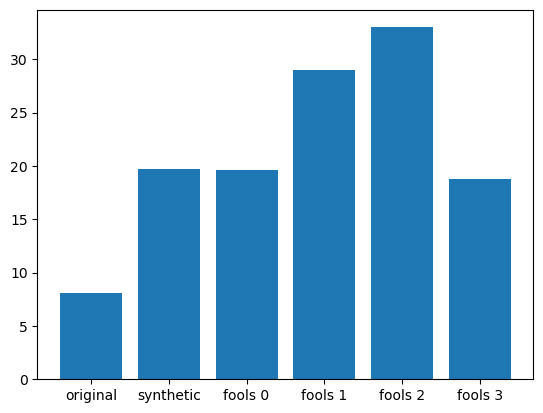

In [30]:
import matplotlib.pyplot as plt
plt.bar(
    ['original', 'synthetic', 'fools 0', 'fools 1', 'fools 2', 'fools 3'],
    [
        mean(original_hypotheses_len),
        mean(generated_hypotheses_len),
        mean(adv_generated_hypothesis_len[0]),
        mean(adv_generated_hypothesis_len[1]),
        mean(adv_generated_hypothesis_len[2]),
        mean(adv_generated_hypothesis_len[3]),
    ],
)